# RESOLVING KNAPSACK 0/1 USING GA
l'idea del notebook di oggi è quello di risolvere il *knapsack 0/1* tramite una strategia evolutiva abbastanza semplice da seguire:
ogni individuo sarà semplicemente una lista booleana che dice se inserire o meno l'elemento ad esso associato nella sacca

In [415]:
import numpy as np
import random as rn

In [416]:
NUMERO_ELEMENTI = 80
CAPACITA = NUMERO_ELEMENTI*50
DIMENSIONE_POPOLAZIONE = NUMERO_ELEMENTI * 2
NUMER0_GENERAZIONI = int(NUMERO_ELEMENTI * 1)
TEST_SIZE = 50

In [417]:
# l'idea è di dare una probabilità iniziale di scelta pari alla "frazione di peso massimo sul peso totale"
def compute_probability(elementi, capacità):
    pesi = elementi[:, 1:]
    peso_totale = np.sum(pesi)
    return capacità / peso_totale

In [418]:
def random_solution(elementi, p = 0.5):
    solution = np.array([-1 if rn.uniform(0, 1) > p else i for i in range (len(elementi))])
    return solution

In [419]:
def weight_function(elementi_inseriti):
    return np.sum(elementi_inseriti.T[1])

In [420]:
def value_function(element_inseriti):
    return np.sum(element_inseriti.T[0])

In [421]:
# chiaramente la fitness function è il valore totale degli oggetti inseriti nella sack
def fitness_function(elementi_inseriti):
    return value_function(elementi_inseriti) + weight_function(elementi_inseriti)/CAPACITA

In [422]:
# la funzione per rendere ammissibile una soluzione è abbastanza semplice ed intuitiva:
# data una soluzione randomica iniziale quello che andiamo a fare è 
# togliere casualmente uno ad uno degli oggetti fino a quando il peso è ammissibile
# notiamo che useremo la funzione sia per inizializzare la popolazione sia che per sistemare i figli nati nei crossover
def feasible_solution(elementi, capacità, solution):
    indici = solution[solution != -1]
    choosen = elementi[indici]
    np.random.shuffle(indici)
    while np.sum(choosen[:, 1:]) > capacità:
        solution[indici[0]] = -1
        indici = solution[solution != -1]
        choosen = elementi[indici]
        np.random.shuffle(indici)
    return solution

In [423]:
elementi = np.array([[1, 3], [3, 2], [1, 5], [2, 2], [3, 4]])
capacità = 10
p = compute_probability(elementi, capacità)
fs = feasible_solution(elementi, capacità, random_solution(elementi, p))
#print(f"{elementi[fs[fs!=-1]]}")

In [424]:
def get_population(elementi, capacità, p):
    return np.array([feasible_solution(elementi, capacità, random_solution(elementi, p)) for _ in range (DIMENSIONE_POPOLAZIONE)])
#print(population)

In [425]:
# utilizzeremo una tournament selection
def tournament_selection(population, elementi, fit, k = 3):
    tournament = rn.choices(population, k=k)
    tournament = sorted(tournament, key = lambda x:fit(elementi[x][x!=-1]), reverse = True)
    return tournament[0]


In [426]:
pop = get_population(elementi, capacità, 0.5)
print(tournament_selection(pop, elementi, fitness_function, 3))

[-1 -1  2 -1  4]


In [427]:
# che tipo di crossover useremo? useremo una 2 point - crossover per comodità
def two_point_crossover(elementi, capacità, parent_a, parent_b):
    k1 = rn.randrange(0, len(parent_a))
    k2 = rn.randrange(k1, len(parent_a))
    offspring_a = np.concatenate((parent_a[:k1], parent_b[k1:k2], parent_a[k2:]), axis = 0)
    offspring_b = np.concatenate((parent_b[:k1], parent_a[k1:k2], parent_b[k2:]), axis = 0)
    return feasible_solution(elementi, capacità, offspring_a), feasible_solution(elementi, capacità, offspring_b)

In [428]:
# la mutazione è molto semplice: prendiamo indici a caso con probabilità p_m e in quegli indici 
# eseguiamo una flip mutation. dopodiché ricontrolliamo che la soluzione sia ammissibile
def mutation(elementi, capacità, solution, p_m):
    index_of_mutation = []
    for i in range (len(solution)):
        if rn.uniform(0, 1) < p_m:
            index_of_mutation.append(i)
    for index in index_of_mutation:
        solution[index] = index if solution[index] == -1 else -1
    return feasible_solution(elementi, capacità, solution)

In [429]:
# non usiamo elitismo in questo caso perché no lol
def generation(elementi, capacità, population, fit, crossover, p_m, k_tour = 3, el = False, k_el = 1):
    new_gen = []
    c = 0
    if el == True:
        new_gen = sorted(population,  key = lambda x: fit(elementi[x][x!=-1]), reverse = True)[:k_el]
        c = k_el
    #for i in range (k_el):
        #new_gen[i] = mutation(elementi, capacità, new_gen[i], p_m)
    for i in range (c, len(population) // 2):
        parent_a = tournament_selection(population, elementi, fit, k = 3)
        parent_b = tournament_selection(population, elementi, fit, k = 3)
        son_a, son_b = crossover(elementi, capacità, parent_a, parent_b)
        son_a = mutation(elementi, capacità, son_a, p_m)
        son_b = mutation(elementi, capacità, son_b, p_m)
        new_gen.append(son_a)
        new_gen.append(son_b)
    new_gen = np.array(new_gen)
    best = sorted(new_gen, key = lambda x: fit(elementi[x][x!=-1]), reverse = True)[0]
    return new_gen, best

In [430]:
def knapsack_ga(profitti, pesi, capacità, fit, crossover, p_m, k_tour = 3, el = False, k_el = 1):
    elementi = np.array(list(zip(profitti, pesi)))
    p = compute_probability(elementi, capacità)
    population = get_population(elementi, capacità, p)
    history = []
    for i in range (NUMER0_GENERAZIONI):
        population, best = generation(elementi, capacità, population, fit, crossover, p_m, k_tour, el, k_el)
        history.append(best)
    return history, history[-1]

In [431]:
# preso su internet il primo codice di un knapsack funzionante per testare l'efficacia della ga
def knapSack(W, wt, val, n):
    K = [[0 for x in range(W + 1)] for x in range(n + 1)]
    # Build table K[][] in bottom up manner
    for i in range(n + 1):
        for w in range(W + 1):
            if i == 0 or w == 0:
                K[i][w] = 0
            elif wt[i-1] <= w:
                K[i][w] = max(val[i-1]
                              + K[i-1][w-wt[i-1]],
                              K[i-1][w])
            else:
                K[i][w] = K[i-1][w]
    return K[n][W]

In [432]:
profitti = np.array([rn.randint(1, 150) for _ in range (NUMERO_ELEMENTI)])
pesi = np.array([rn.randint(1, CAPACITA) for _ in range (NUMERO_ELEMENTI)])
elementi = np.array(list(zip(profitti, pesi)))
n = len(profitti)

In [433]:
import time

In [434]:
st = time.time()
sol = knapSack(CAPACITA, pesi, profitti, n)
normal_time = time.time() - st
print(f"{sol} : {normal_time}")
st = time.time()
history, ga_sol = knapsack_ga(profitti, pesi, CAPACITA, fitness_function, two_point_crossover, 0.03 , 3, True, 1)
ga_sol = value_function(elementi[ga_sol][ga_sol!=-1])
ga_time = time.time() - st
print(f"{ga_sol} : {ga_time}")
# accuracy
print(f"{ga_sol/sol}")

995 : 0.3591122627258301
815 : 0.961087703704834
0.8190954773869347


In [435]:
REAL_SOL = -1
try:
    REAL_SOL = sol
except:
    print("sol non ancora calcolata")

In [436]:
import matplotlib.pyplot as plt

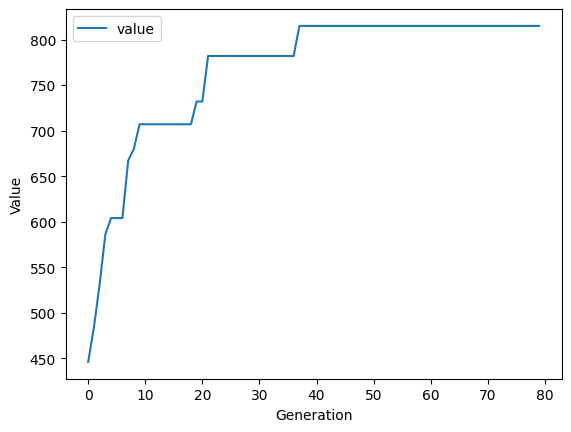

In [437]:
fitness_history = np.array([value_function(elementi[x][x!=-1]) for x in history])
plt.plot(fitness_history, label = "value")
plt.ylabel('Value')
plt.xlabel('Generation')
plt.legend()
plt.show()

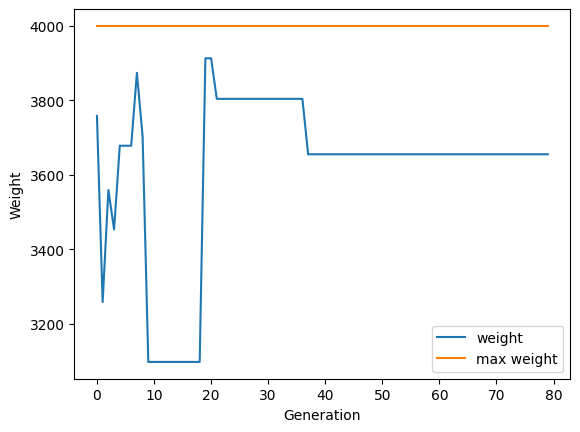

In [438]:
weight_history = np.array([weight_function(elementi[x][x!=-1]) for x in history])
plt.plot(weight_history, label = "weight")
plt.plot(np.ones(NUMER0_GENERAZIONI)*CAPACITA, label="max weight")
plt.ylabel('Weight')
plt.xlabel('Generation')
plt.legend()
plt.show()

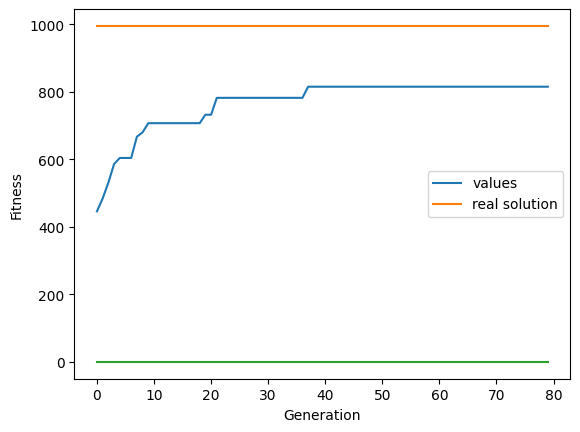

In [439]:
fitness_history = np.array([value_function(elementi[x][x!=-1]) for x in history])
best_solution = np.ones(NUMER0_GENERAZIONI)*sol
zero = np.zeros(NUMER0_GENERAZIONI)*0
plt.plot(fitness_history, label = "values")
plt.plot(best_solution, label = "real solution")
plt.plot(zero)
plt.ylabel('Fitness')
plt.xlabel('Generation')
plt.legend()
plt.show()

In [440]:
# funzione per definire l'accuratezza della soluzione
def compute_accuracy(sol, profitti, pesi):
    elementi = np.array(list(zip(profitti, pesi)))
    _, ga_sol = knapsack_ga(profitti, pesi, CAPACITA, fitness_function, two_point_crossover, 0.05 , 3, True, 1)
    ga_sol = value_function(elementi[ga_sol][ga_sol!=-1])
    return ga_sol / sol

In [441]:
def ga_vs_dp():
    profitti = np.array([rn.randint(1, 150) for _ in range (NUMERO_ELEMENTI)])
    pesi = np.array([rn.randint(1, CAPACITA) for _ in range (NUMERO_ELEMENTI)])
    accuracies = []
    weights = []
    sol = knapSack(CAPACITA, pesi, profitti, len(profitti))
    for _ in range (TEST_SIZE):
        accuracies.append(compute_accuracy(sol, profitti, pesi))
    return accuracies

In [442]:
accuracies_history = ga_vs_dp()
mean = sum(accuracies_history)/TEST_SIZE
print(mean)

0.8096007984031935


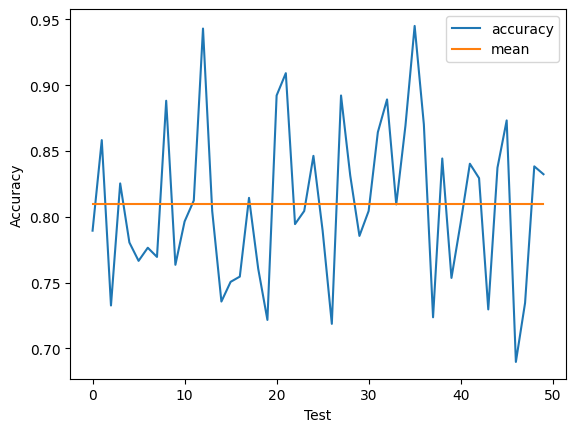

In [443]:
plt.plot(accuracies_history, label = "accuracy")
plt.plot(np.ones(TEST_SIZE)*mean, label="mean")
plt.ylabel("Accuracy")
plt.xlabel("Test")
plt.legend()
plt.show()